# Cities in Motion: Student Hackathon

This notebook covers initial data exploration of the Urban Scanner dataset.

In [1]:
import os
os.chdir("..")

from pandas import DataFrame
from geopandas import GeoDataFrame
import pandas as pd
import numpy as np

from data import *
from model import *
from preprocess import *
from postprocess import *

run_dir = "run/model-2025-10-16_04-18"
LAYERS = [3, 32, 64, 128, 256, 128, 64, 32, 3]

model = PINN(layers=LAYERS)


In [2]:
def load_trained_pinn(layers, run_dir, device="mps", use_best=True):
    """
    Load a trained PINN model from a given run directory.

    Args:
        layers (list[int]): Network architecture, e.g. [3, 128, 128, 64, 3]
        run_dir (str): Path to run directory containing model weights, e.g. "run/model-2025-10-16_12-00"
        device (str): "cpu" or "cuda"
        use_best (bool): If True, loads 'best_model.pt'; otherwise loads 'final_model.pt'

    Returns:
        model (PINN): The loaded and ready-to-evaluate PINN model.
    """
    # --- Rebuild model ---
    model = PINN(layers, activation=Sin())
    model.to(device)

    # --- Choose which weights to load ---
    model_path = f"{run_dir}/best_model.pt" if use_best else f"{run_dir}/final_model.pt"

    # --- Load weights ---
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    print(f"Loaded {'best' if use_best else 'final'} model from: {model_path}")
    return model

model = load_trained_pinn(LAYERS, run_dir, device="mps")

RuntimeError: Error(s) in loading state_dict for PINN:
	Missing key(s) in state_dict: "net.10.weight", "net.10.bias", "net.12.weight", "net.12.bias", "net.14.weight", "net.14.bias". 
	size mismatch for net.0.weight: copying a param with shape torch.Size([64, 3]) from checkpoint, the shape in current model is torch.Size([32, 3]).
	size mismatch for net.0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for net.2.weight: copying a param with shape torch.Size([128, 64]) from checkpoint, the shape in current model is torch.Size([64, 32]).
	size mismatch for net.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for net.4.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for net.6.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 128]).
	size mismatch for net.6.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for net.8.weight: copying a param with shape torch.Size([3, 64]) from checkpoint, the shape in current model is torch.Size([128, 256]).
	size mismatch for net.8.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([128]).

AttributeError: 'PINN' object has no attribute 'device'

In [3]:
fishnets = read_fishnet(verbose=True)
fishnets.keys()

dict_keys(['FishCenterJoin.shp', 'fishnet.shp', 'fishnetlable.shp'])

In [8]:
base_gdf = fishnets.get("fishnet.shp")

                  x             y
0     294025.428773  4.844461e+06
1     293944.744788  4.844849e+06
2     293866.210663  4.845275e+06
3     298813.571458  4.831822e+06
4     298818.683000  4.832314e+06
...             ...           ...
2743  298318.683000  4.844814e+06
2744  298318.683000  4.845314e+06
2745  298318.683000  4.845814e+06
2746  298318.683000  4.846314e+06
2747  298346.278606  4.846684e+06

[2748 rows x 2 columns]


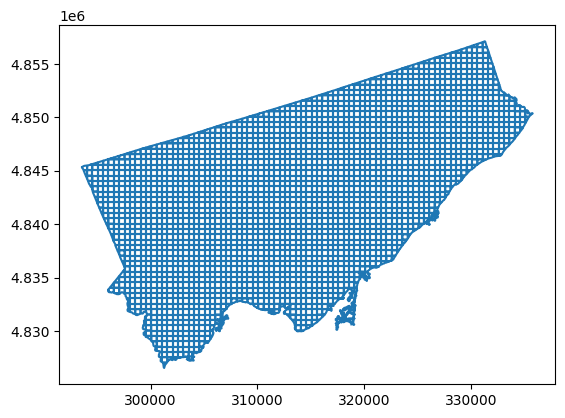

In [22]:
import geopandas as gpd
import numpy as np

def aggregate_fishnet(gdf, agg_size=500):
    """
    Aggregate a regular square fishnet GeoDataFrame (e.g. 100x100 m)
    into larger grid cells (e.g. 500x500 m).

    Parameters
    ----------
    gdf : GeoDataFrame
        Input fishnet with square polygons in a projected CRS (meters).
    agg_size : int, optional
        Target grid size in meters (default = 500).

    Returns
    -------
    GeoDataFrame
        Aggregated fishnet with merged geometries (no attributes).
    """
    if not gdf.crs or not gdf.crs.is_projected:
        raise ValueError("Input GeoDataFrame must use a projected CRS in meters.")

    # Get reference origin (lower-left corner)
    minx, miny, _, _ = gdf.total_bounds

    # Compute centroid coordinates
    centroids = gdf.geometry.centroid
    cx, cy = centroids.x, centroids.y

    # Determine which 500m cell each feature belongs to
    gx = np.floor((cx - minx) / agg_size)
    gy = np.floor((cy - miny) / agg_size)
    group_id = gx.astype(int).astype(str) + "_" + gy.astype(int).astype(str)

    # Dissolve geometries by group ID (drop attributes)
    agg = gdf[["geometry"]].dissolve(by=group_id)

    # Clean index and reset CRS
    agg = agg.reset_index(drop=True)
    agg.crs = gdf.crs

    return agg

base = aggregate_fishnet(base_gdf, 500)
base.boundary.plot()

base["x"] = base.geometry.centroid.x
base["y"] = base.geometry.centroid.y

base = base[["x", "y"]]
print(base)

In [24]:
x = base.x
y = base.y

# Hour values: 8 → 15 (0.5 increments)
hours = np.arange(8, 15.5, 0.5)  # includes 15.0

# Repeat each (x, y) pair for each hour
xy_repeated = np.repeat(np.column_stack((x, y)), len(hours), axis=0)

# Tile hour values across all points
hour_tiled = np.tile(hours, len(x))

# Combine into single array: [x, y, hour]
test_array = np.column_stack((xy_repeated, hour_tiled))

In [29]:
loader = load_loader(n_colloc=20000).prepare_data().preprocess()

# === Scale and convert ===
xyt_scaled = loader.scaler_xyt.transform(test_array)

# Convert to torch tensor for model input
xyt = torch.tensor(xyt_scaled, dtype=torch.float32, device=loader.device)

with torch.no_grad():
    D_pred, u_pred, v_pred = model.predict_fields(xyt)

=== Pollution Data Summary ===
Total rows: 2,274
Columns: ['r3_key', 'x_meter', 'y_meter', 'hour', 'NO2', 'wind_x', 'wind_y', 'S']

Feature ranges (original scale):
  x_meter    min=294020.507  max=335469.631  mean=313042.063
  y_meter    min=4827313.776  max=4857008.441  mean=4842426.973
  hour       min=     8.000  max=    15.000  mean=    11.617
  NO2        min=     0.001  max=     0.075  mean=     0.024
  wind_x     min=   -33.033  max=    27.427  mean=    -2.554
  wind_y     min=   -32.519  max=    33.799  mean=    -5.281
  S          min=     0.000  max=     0.000  mean=     0.000

Preprocessed:
  Train samples: 1,137
  Test samples:  1,137
  Collocation pts: 20,000
  Scaling: on
  Device: mps

--- Verbose Info ---
Tensor shapes:
  xyt   : (1137, 3)
  D     : (1137, 1)
  u     : (1137, 1)
  v     : (1137, 1)
  S     : (1137, 1)

Scaled input ranges:
  x-scaled  min=  0.0164  max=  0.9861
  y-scaled  min=  0.0292  max=  0.9872
  t-scaled  min=  0.1429  max=  1.0000

Original outp

RuntimeError: Tensor for argument weight is on cpu but expected on mps

In [30]:
loader.device

'mps'